<a href="https://colab.research.google.com/github/mz-zarei/TimeSeriesAnalysis/blob/main/PedestrianFlowForecasting/PedCrossVolumeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from IPython.display import display
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline

# 1. Read Data

In [256]:
# Read and transform the data
def load_transform(path_to_data, verbos=False):
    df_all = pd.read_csv(path_to_data, delimiter=';')
    ## Combine date/time columns and change the type to datetime 
    df_all['date'] = pd.to_datetime(df_all['date'] + ' ' + df_all['time'], format='%Y-%m-%d %H:%M:%S')
    ## Set index as date column and sort
    df_all.set_index('date', inplace=True)
    df_all.sort_index(inplace=True)
    ## Drop unused columns
    df_all.drop(columns=['latitude', 'longitude', 'time', 'vol_vehicle'], inplace=True)

    if verbos:
        # Show the date range
        print(f'Data From {df_all.index.min()} to {df_all.index.max()}')
        # Show first 10 rows
        display(df_all.head())
        # Show unique intersections names
        print(df_all.name.unique())
    return df_all


path_to_data = './data/20180525-20200416-Milton-Ped-Volume-Per-Crosswalk.csv'
df_all = load_transform(path_to_data, verbos=True)

Data From 2018-05-25 15:00:00 to 2020-04-16 23:45:00


,id,name,ped_N,ped_S,ped_E,ped_W
date,,,,,,
2018-05-25 15:00:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0
2018-05-25 15:15:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0
2018-05-25 15:30:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0
2018-05-25 15:45:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0
2018-05-25 16:00:00,af48a872-12a8-4142-be64-8f6cf84e58f9,Thompson Road and McCuaig Drive,0,0,0,0


['Thompson Road and McCuaig Drive' 'Thompson Road and Nipissing Road'
 'James Snow Parkway and Derry Road' 'Thompson Road and Laurier Avenue'
 'Thompson Road and Main Street' 'Ontario Street South and Childs Drive'
 'Ontario Street South and Pine Street'
 'Main Street East and Ontario Street North'
 'Main Street East and Mall Entrance'
 'Bronte Street North and Main Street West'
 'Martin Street and Main Street East' 'Main Street and Sherwood'
 'Laurier Avenue and Ontario Street South'
 'Louis St Laurent Avenue and Commercial Plaza'
 'Thompson Road and Drew Centre'
 'Louis St Laurent Avenue and Farmstead Drive'
 'Main Street E and Harris / Pearson'
 'Main Street East and Leisure Centre Driveway'
 'Main Street East and Maple / Sinclair' 'Fifth Line and Yukon Court'
 'Thompson Road North and Maple Avenue'
 'Thompson Road North and Woodward Avenue'
 'Steeles Avenue East and Martin Street'
 'Main Street West and Scott Boulevard']


# 3. EDA

In [306]:
def get_df_intersection(df_all, int_name):
    # choose one/more intersection
    df = df_all[df_all['name'] == int_name]
    # keep data after 2019-01-01 befor 2020-01-01
    df = df[(df.index > "2019-01-01") & (df.index < "2020-01-01")]
    return df

# Summary statistics
int_name = 'Ontario Street South and Pine Street'
df_int = get_df_intersection(df_all, int_name)
df_int.describe()

,ped_N,ped_S,ped_E,ped_W
count,"34,993.0","34,993.0","34,993.0","34,993.0"
mean,0.8,0.3,0.5,0.4
std,1.5,0.6,1.2,0.8
min,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0
75%,1.0,0.0,1.0,1.0
max,38.0,22.0,83.0,32.0


Duplicate dates in our data (before):  0


,ped_N,ped_S,ped_E,ped_W
count,365.0,365.0,365.0,365.0
mean,79.1,24.1,45.0,38.4
std,38.9,10.5,29.7,15.7
min,10.0,2.0,0.0,5.0
25%,58.0,17.0,27.0,27.0
50%,78.0,23.0,47.0,38.0
75%,96.0,29.0,65.0,47.0
max,441.0,81.0,287.0,107.0


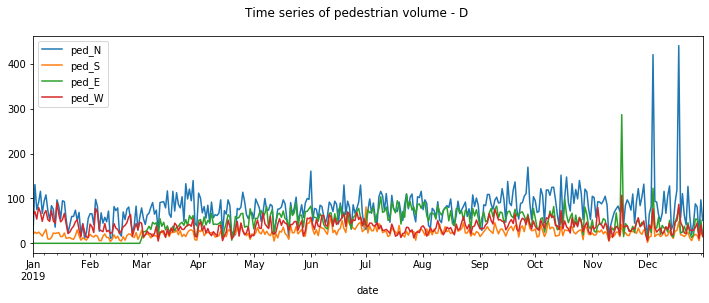

In [307]:
def plot_ts(df_int, agg_level = 'D', show_stat=False):
    # Resample data to get daily or weekly or monthly counts
    df_int_r = df_int.resample(agg_level).sum()

    # Check for duplicate index values
    print('Duplicate dates in our data (before): ', df_int_r.index.duplicated().sum())

    # Summary statistics
    if show_stat:
        display(df_int_r.describe())

    # Plotting the time series of Ped counts for each crossing
    fig, axs = plt.subplots(1, figsize=(12, 4))
    fig.suptitle('Time series of pedestrian volume - ' + agg_level)

    df_int_r.ped_N.plot(ax=axs)
    df_int_r.ped_S.plot(ax=axs)
    df_int_r.ped_E.plot(ax=axs)
    df_int_r.ped_W.plot(ax=axs)
    axs.legend()
    plt.show()

plot_ts(df_int, show_stat=True)

# 4. Compute true volume ratio for each approach

In [308]:
def get_true_ratio(df_int):
    # average annual daily pedestrian traffic
    AADPT = df_int.ped_N.sum()+df_int.ped_S.sum()+df_int.ped_W.sum()+df_int.ped_E.sum()
    
    # true volume ratios 
    ratio_N_true = 0 if AADPT==0 else df_int.ped_N.sum() / AADPT 
    ratio_S_true = 0 if AADPT==0 else df_int.ped_S.sum() / AADPT 
    ratio_W_true = 0 if AADPT==0 else df_int.ped_W.sum() / AADPT 
    ratio_E_true = 0 if AADPT==0 else df_int.ped_E.sum() / AADPT 
    return AADPT, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true


AADPT, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true = get_true_ratio(df_int)

print(f'AADPT: {AADPT}')
print(f'True Ratio N:{ratio_N_true:.{2}f}, S:{ratio_S_true:.{2}f}')
print(f'           W:{ratio_W_true:.{2}f}, E:{ratio_E_true:.{2}f}')

AADPT: 68143
True Ratio N:0.42, S:0.13
           W:0.21, E:0.24


# 5. Calculate short-term counts for each approach

In [309]:
def filter_valid_stc(df_int, verbos=False):
    # Resample data to get Hourly counts
    df_int_h = df_int.resample('H').sum()

    # Keep valid hours for short-term count 7am-9am, 11am-2pm, 3pm-6pm
    df_int_h_valid = pd.concat([df_int_h.between_time('7:00', '9:00'),
                            df_int_h.between_time('11:00', '14:00'),
                            df_int_h.between_time('15:00', '18:00')])
    
    # Resample data to get daily shour-term counts
    df_int_d = df_int_h_valid.resample('D').sum()

    # Keep valid months (9,10,11) and day of weeks Tuesdays (1), Wednesdays (2), and Thursdays (3)
    df_int_d_valid = df_int_d[df_int_d.index.dayofweek.isin([1,2,3]) & df_int_d.index.month.isin([4,5,6,9,10,11])]
    
    # check if filters worked
    if verbos:
        print('Hours: ', df_int_h_valid.index.hour.unique())
        print('Day of Weeks: ', df_int_d_valid.index.day_of_week.unique())
        print('Months: ', df_int_d_valid.index.month.unique())

    # Exclude the holidays
    holidays = ['2019-01-01','2019-01-02', '2019-01-03', '2019-01-20',
                '2019-02-17', 
                '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19', '2019-03-20']
    df_int_d_valid = df_int_d_valid[~df_int_d_valid.index.isin(holidays)]
    return df_int_d_valid


df_int_d_valid = filter_valid_stc(df_int)
df_int_d_valid

,ped_N,ped_S,ped_E,ped_W
date,,,,
2019-04-02,86,17,43,39
2019-04-03,50,26,33,27
2019-04-04,73,12,45,33
2019-04-09,50,14,36,20
2019-04-10,56,14,35,18
...,...,...,...,...
2019-11-20,81,17,32,32
2019-11-21,78,15,27,25
2019-11-26,96,26,42,43


# 6. Calculate volume ratio error from ST counts

In [310]:
def get_ratio_error(df_int_d_valid, df_int):
    # calculate true ratios
    _, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true = get_true_ratio(df_int)
    
    # total short term count for each day
    df_int_d_valid['total'] = df_int_d_valid.ped_N + df_int_d_valid.ped_S + df_int_d_valid.ped_W + df_int_d_valid.ped_E

    # drop those days with zero total counts
    print(f'valid STC: {len(df_int_d_valid)}, droped zero counts: {len(df_int_d_valid[df_int_d_valid.total == 0])}')
    df_int_d_valid.drop(df_int_d_valid[df_int_d_valid.total == 0].index, inplace=True)

    # volume ratio for each approach
    df_int_d_valid['ratio_N'] = df_int_d_valid.ped_N / df_int_d_valid.total
    df_int_d_valid['ratio_S'] = df_int_d_valid.ped_S / df_int_d_valid.total
    df_int_d_valid['ratio_W'] = df_int_d_valid.ped_W / df_int_d_valid.total
    df_int_d_valid['ratio_E'] = df_int_d_valid.ped_E / df_int_d_valid.total

    # volume ratio error for each approach
    df_int_d_valid['ratio_N_err'] = (df_int_d_valid.ped_N / df_int_d_valid.total - ratio_N_true)/(ratio_N_true + 0.0001)
    df_int_d_valid['ratio_S_err'] = (df_int_d_valid.ped_S / df_int_d_valid.total - ratio_S_true)/(ratio_S_true + 0.0001)
    df_int_d_valid['ratio_W_err'] = (df_int_d_valid.ped_W / df_int_d_valid.total - ratio_W_true)/(ratio_W_true + 0.0001)
    df_int_d_valid['ratio_E_err'] = (df_int_d_valid.ped_E / df_int_d_valid.total - ratio_E_true)/(ratio_E_true + 0.0001)

    df_int_d_valid['ratio_err_avg'] = 0.25*(abs(df_int_d_valid['ratio_E_err'])+abs(df_int_d_valid['ratio_W_err'])+
                                        abs(df_int_d_valid['ratio_N_err'])+abs(df_int_d_valid['ratio_N_err']))
    return df_int_d_valid

df_int_d_valid = get_ratio_error(df_int_d_valid, df_int)
df_int_d_valid.head()


valid STC: 78, droped zero counts: 0


,ped_N,ped_S,ped_E,ped_W,total,ratio_N,ratio_S,ratio_W,ratio_E,ratio_N_err,ratio_S_err,ratio_W_err,ratio_E_err,ratio_err_avg
date,,,,,,,,,,,,,,
2019-04-02,86,17,43,39,185,0.5,0.1,0.2,0.2,0.1,-0.3,0.0,-0.0,0.1
2019-04-03,50,26,33,27,136,0.4,0.2,0.2,0.2,-0.1,0.5,-0.0,0.0,0.1
2019-04-04,73,12,45,33,163,0.4,0.1,0.2,0.3,0.1,-0.4,-0.0,0.1,0.1
2019-04-09,50,14,36,20,120,0.4,0.1,0.2,0.3,-0.0,-0.1,-0.2,0.2,0.1
2019-04-10,56,14,35,18,123,0.5,0.1,0.1,0.3,0.1,-0.1,-0.3,0.2,0.2


95% CI for ratio_N_err: (-0.20161186066259487, 0.2373678383528757)
95% CI for ratio_S_err: (-0.4524457592198551, 0.39432874920042116)
95% CI for ratio_W_err: (-0.3938789550328582, 0.18092512290082385)
95% CI for ratio_E_err: (-0.23665943889203028, 0.3867420152285373)


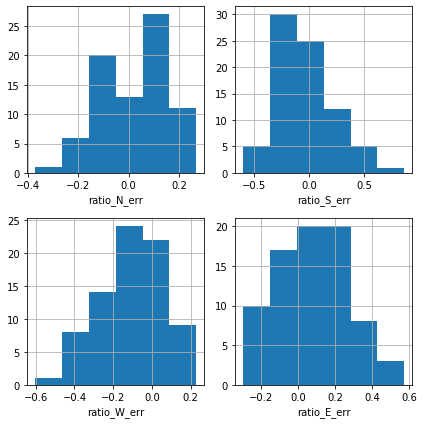

Text(0.5, 1.0, 'AVG volume ratio error')

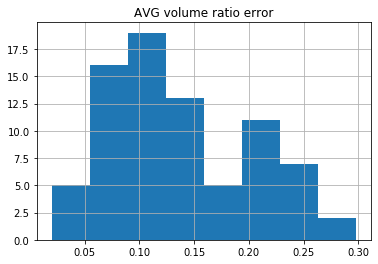

In [311]:
# returns lower and upper bound of 95% CI for given column assuming normal dist
def confidence_interval(df, col):
    mean = df[col].mean()
    sd = df[col].std()
    n = len(df)
    Zstar=1.65

    lcb = mean - Zstar * sd
    ucb = mean + Zstar * sd
    
    return lcb, ucb
    
# Plot the dist of the errors and 95% CI
fig, axes = plt.subplots(2,2, figsize=(6,6))
for ax, col in [(axes[0,0],'ratio_N_err'),(axes[0,1],'ratio_S_err'),
                (axes[1,0],'ratio_W_err'),(axes[1,1],'ratio_E_err')]:
    df_int_d_valid[col].hist(ax=ax, bins=6)
    ax.set_xlabel(col)
    print(f'95% CI for {col}: {confidence_interval(df_int_d_valid, col)}')

plt.tight_layout()
plt.show()

df_int_d_valid['ratio_err_avg'].hist(bins=8) 
plt.title('AVG volume ratio error')   

True ratios: N:0.42, S:0.13, W:0.21, E:0.24


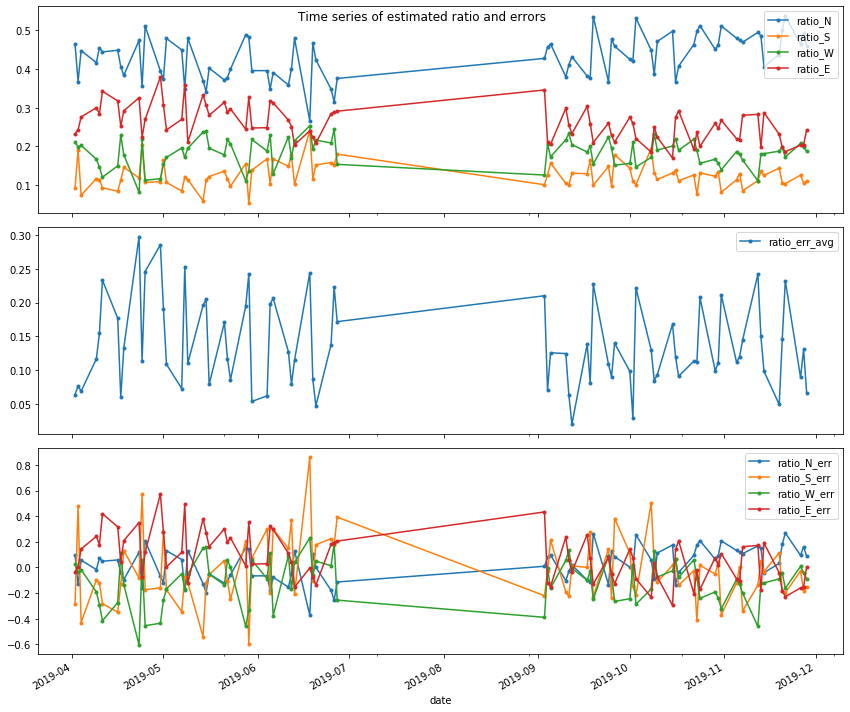

In [312]:
def plot_ts_ratio_err(df_int_d_valid, df_int):
    # Plotting the time series of estimated ratio for each crossing
    fig, axs = plt.subplots(3,1, figsize=(12, 10), sharex=True)
    fig.suptitle('Time series of estimated ratio and errors')

    # calculate true ratios
    _, ratio_N_true, ratio_S_true, ratio_W_true, ratio_E_true = get_true_ratio(df_int)
    print(f'True ratios: N:{ratio_N_true:.{2}f}, S:{ratio_S_true:.{2}f}, W:{ratio_W_true:.{2}f}, E:{ratio_E_true:.{2}f}')

    df_int_d_valid.ratio_N.plot(ax=axs[0], style='.-')
    df_int_d_valid.ratio_S.plot(ax=axs[0], style='.-')
    df_int_d_valid.ratio_W.plot(ax=axs[0], style='.-')
    df_int_d_valid.ratio_E.plot(ax=axs[0], style='.-')

    df_int_d_valid.ratio_err_avg.plot(ax=axs[1], style='.-')

    df_int_d_valid.ratio_N_err.plot(ax=axs[2], style='.-')
    df_int_d_valid.ratio_S_err.plot(ax=axs[2], style='.-')
    df_int_d_valid.ratio_W_err.plot(ax=axs[2], style='.-')
    df_int_d_valid.ratio_E_err.plot(ax=axs[2], style='.-')

    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    axs[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_ts_ratio_err(df_int_d_valid, df_int)

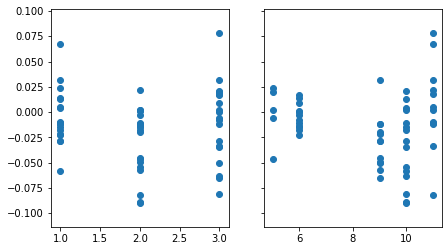

In [302]:
# ratio error distributions for different days of week and months
fig, ax = plt.subplots(1,2, figsize=(7,4), sharey=True)
ax[0].scatter(df_int_d_valid.index.dayofweek, df_int_d_valid.ratio_W_err)
ax[1].scatter(df_int_d_valid.index.month    , df_int_d_valid.ratio_W_err)

# 7. Plot ratio errors for all intersections

Thompson Road and McCuaig Drive
valid STC: 78, droped zero counts: 78
Thompson Road and Nipissing Road
valid STC: 78, droped zero counts: 22
True ratios: N:0.00, S:0.07, W:0.93, E:0.00


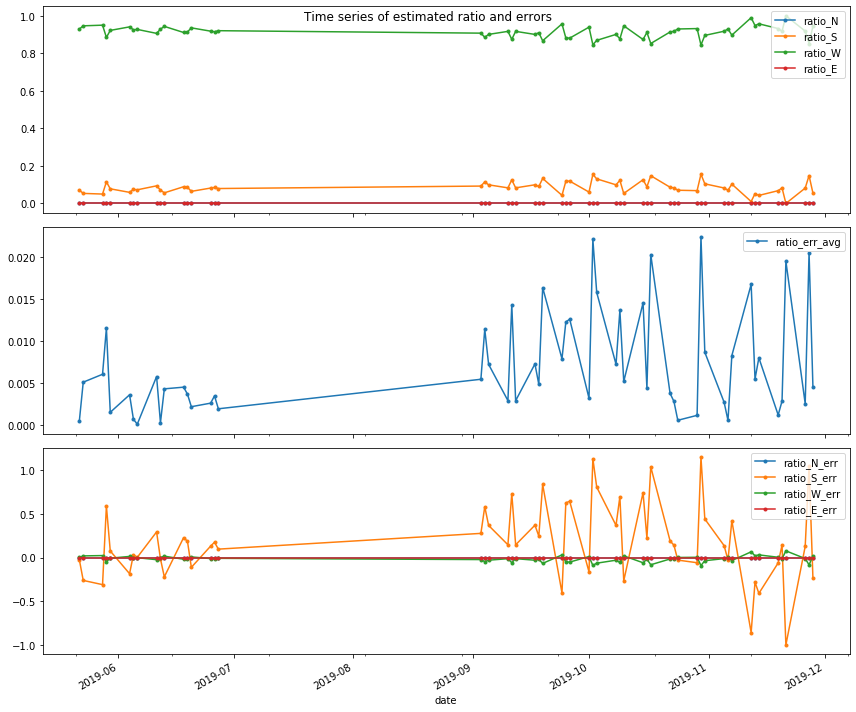

James Snow Parkway and Derry Road
valid STC: 69, droped zero counts: 0
True ratios: N:0.21, S:0.14, W:0.59, E:0.06


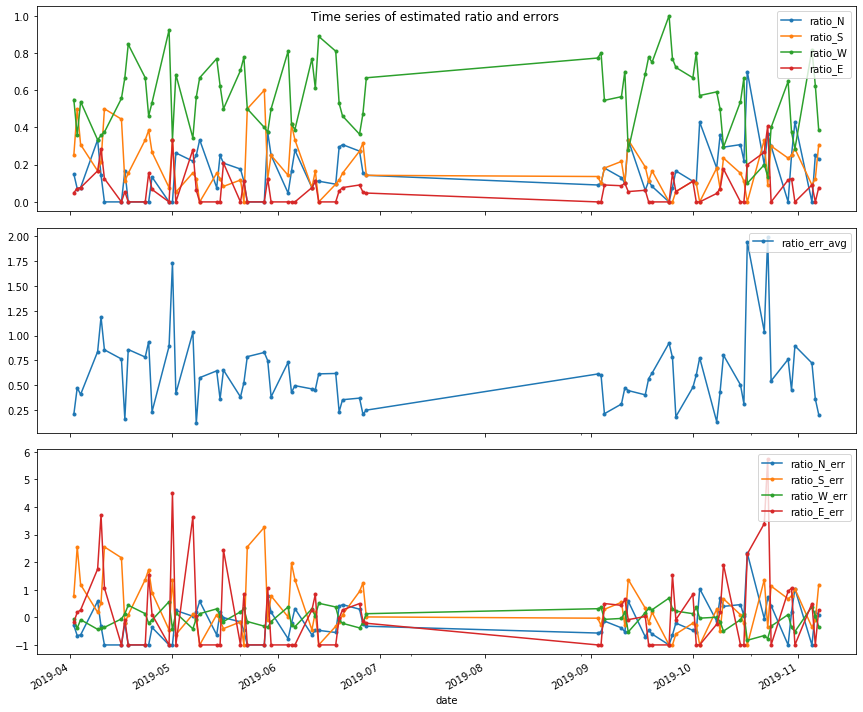

Thompson Road and Laurier Avenue
valid STC: 78, droped zero counts: 1
True ratios: N:0.20, S:0.15, W:0.33, E:0.32


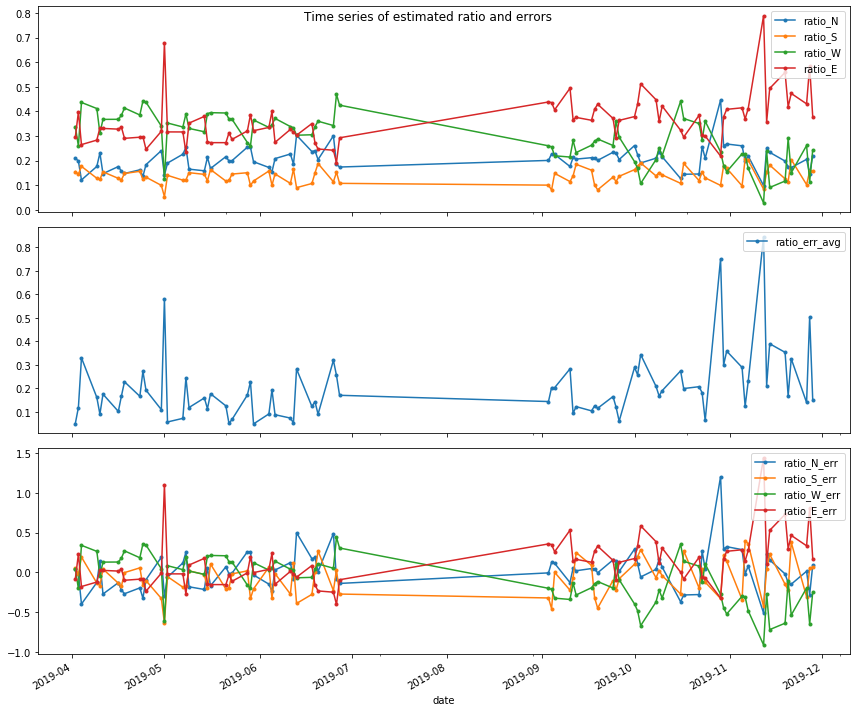

Thompson Road and Main Street
valid STC: 78, droped zero counts: 22
True ratios: N:0.18, S:0.33, W:0.26, E:0.22


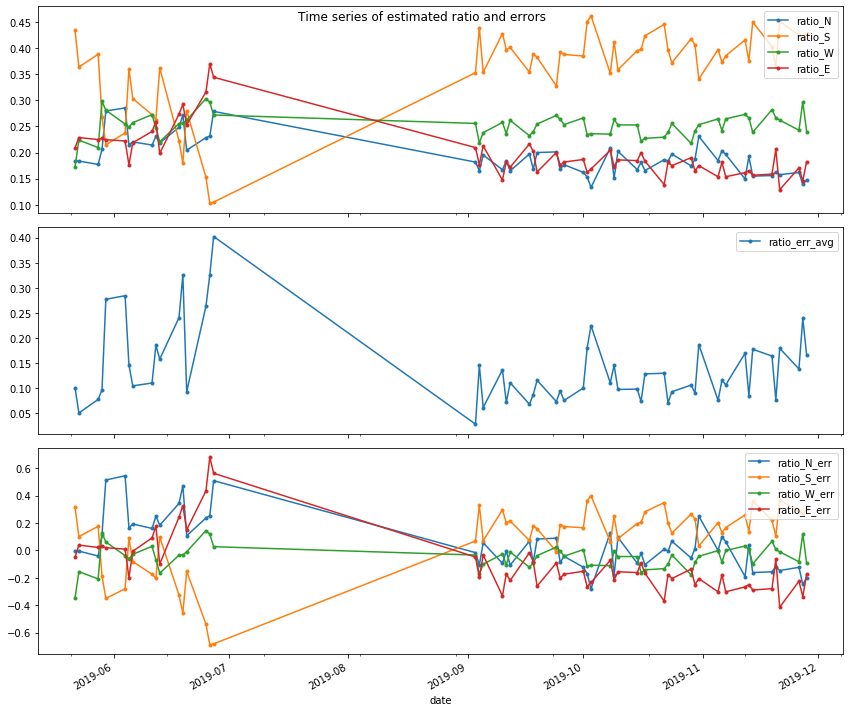

Ontario Street South and Childs Drive
valid STC: 78, droped zero counts: 0
True ratios: N:0.20, S:0.11, W:0.25, E:0.43


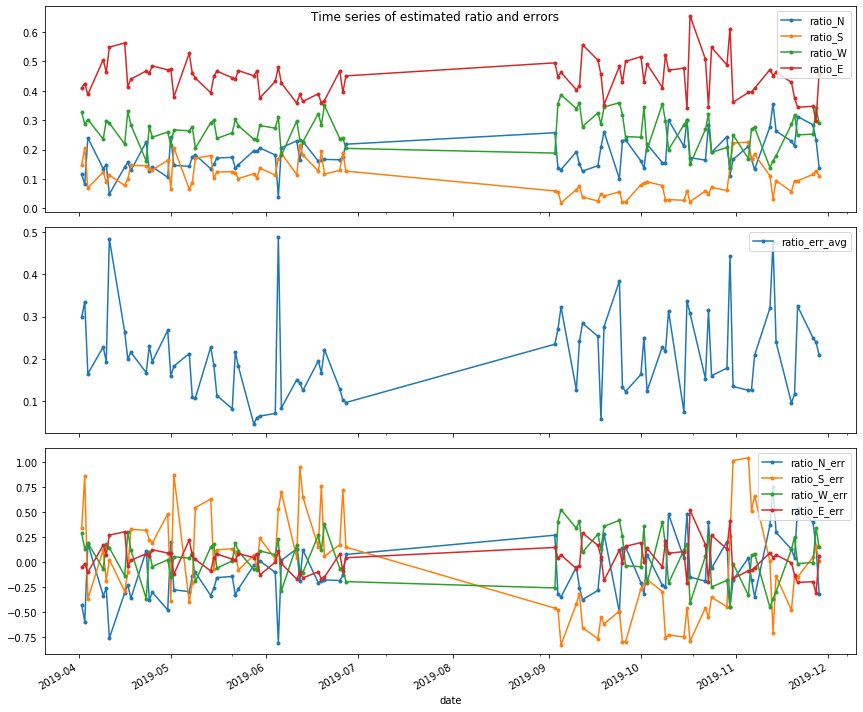

Ontario Street South and Pine Street
valid STC: 78, droped zero counts: 0
True ratios: N:0.42, S:0.13, W:0.21, E:0.24


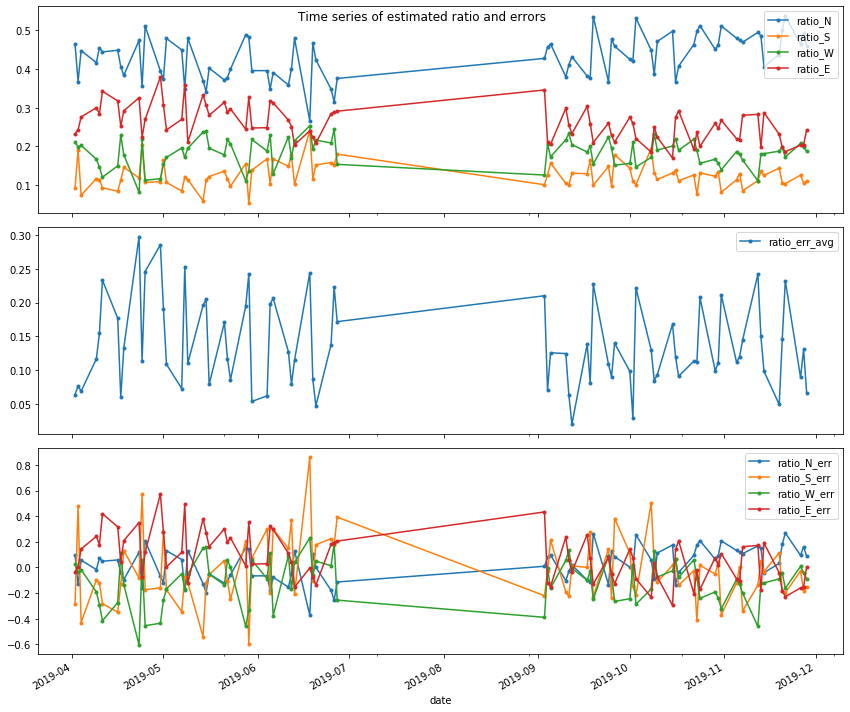

Main Street East and Ontario Street North
valid STC: 78, droped zero counts: 0
True ratios: N:0.24, S:0.32, W:0.20, E:0.25


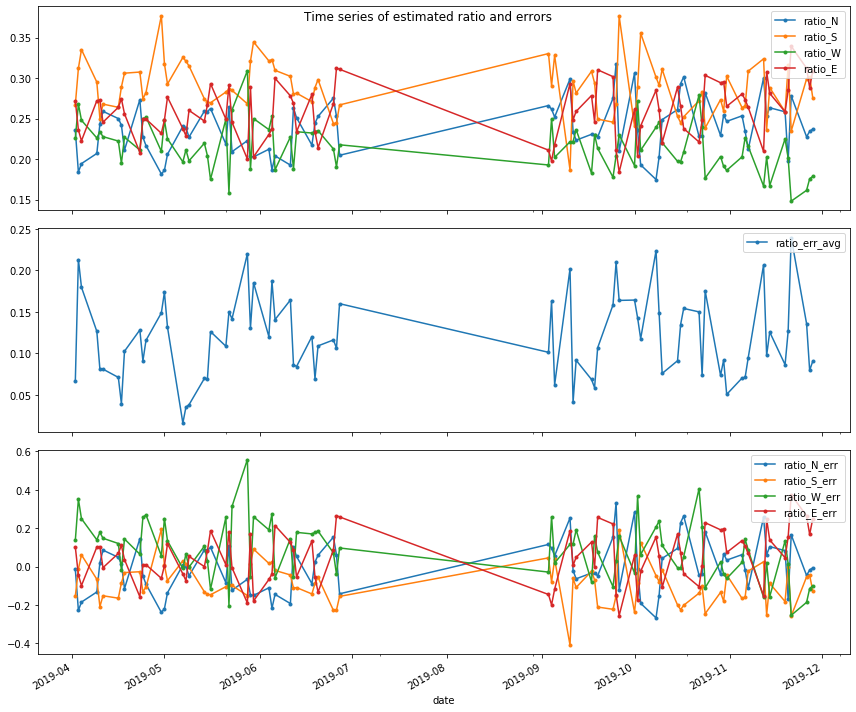

Main Street East and Mall Entrance
valid STC: 78, droped zero counts: 0
True ratios: N:0.00, S:0.70, W:0.00, E:0.30


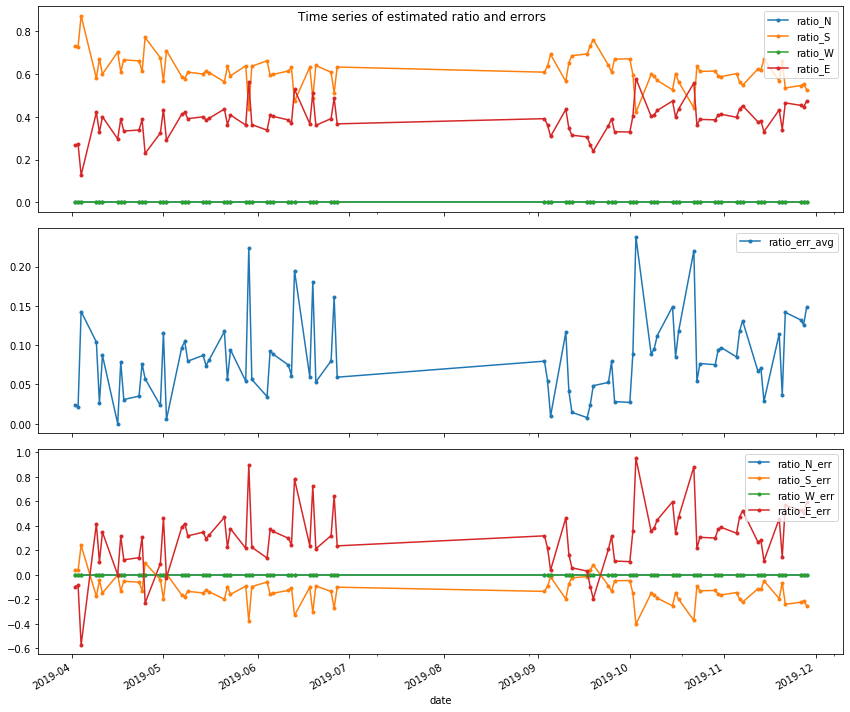

Bronte Street North and Main Street West
valid STC: 78, droped zero counts: 0
True ratios: N:0.11, S:0.55, W:0.10, E:0.24


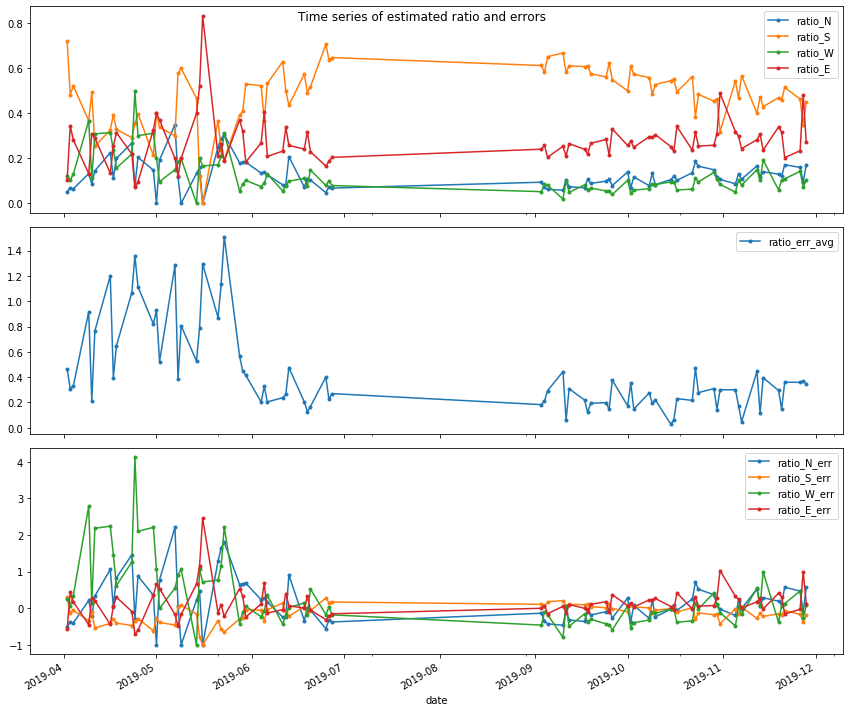

Martin Street and Main Street East
valid STC: 56, droped zero counts: 56
Main Street and Sherwood
valid STC: 51, droped zero counts: 51
Laurier Avenue and Ontario Street South
valid STC: 45, droped zero counts: 0
True ratios: N:0.28, S:0.37, W:0.18, E:0.17


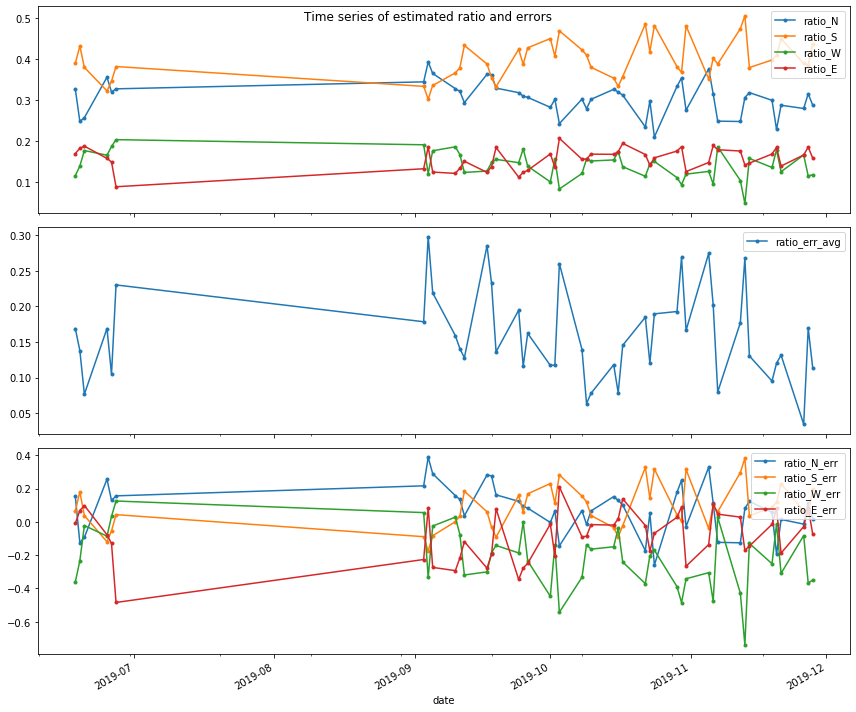

Louis St Laurent Avenue and Commercial Plaza
valid STC: 39, droped zero counts: 5
True ratios: N:0.00, S:0.00, W:0.56, E:0.44


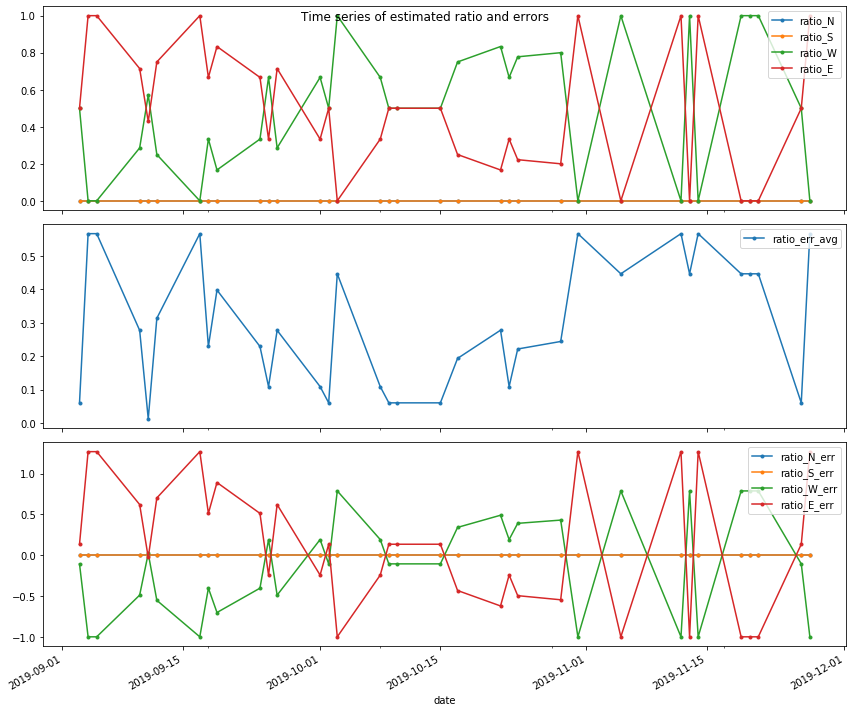

Thompson Road and Drew Centre
valid STC: 39, droped zero counts: 0
True ratios: N:0.34, S:0.13, W:0.23, E:0.30


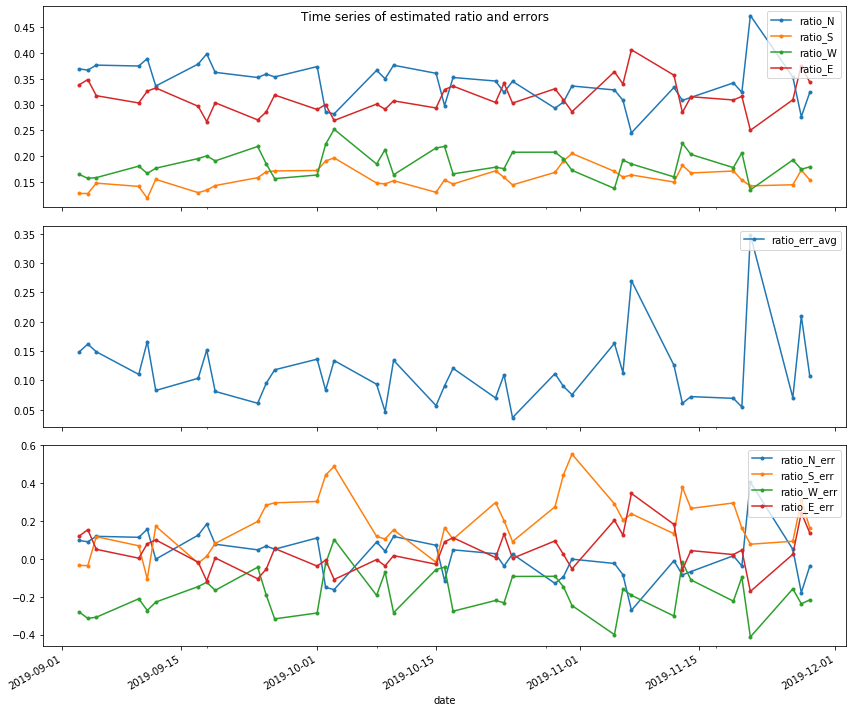

Louis St Laurent Avenue and Farmstead Drive
valid STC: 39, droped zero counts: 0
True ratios: N:0.22, S:0.26, W:0.41, E:0.11


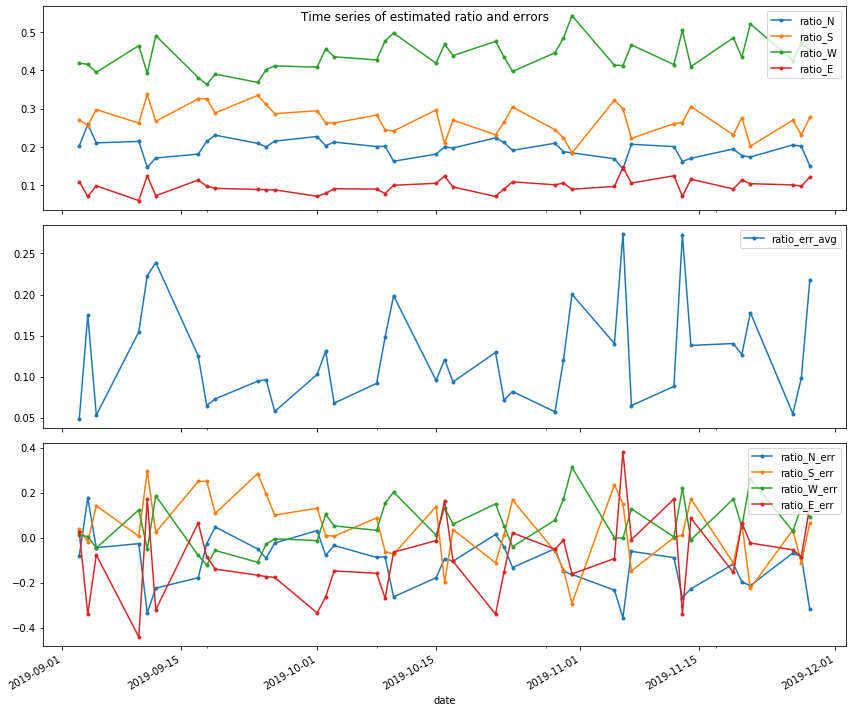

Main Street E and Harris / Pearson
valid STC: 20, droped zero counts: 0
True ratios: N:0.12, S:0.23, W:0.35, E:0.30


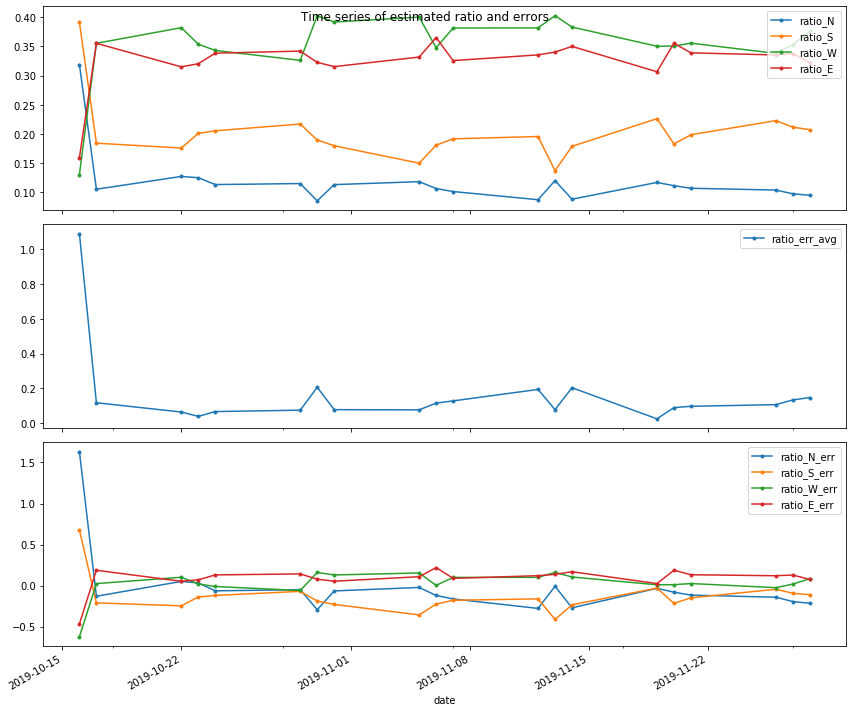

Main Street East and Leisure Centre Driveway
valid STC: 15, droped zero counts: 0
True ratios: N:0.00, S:0.64, W:0.12, E:0.24


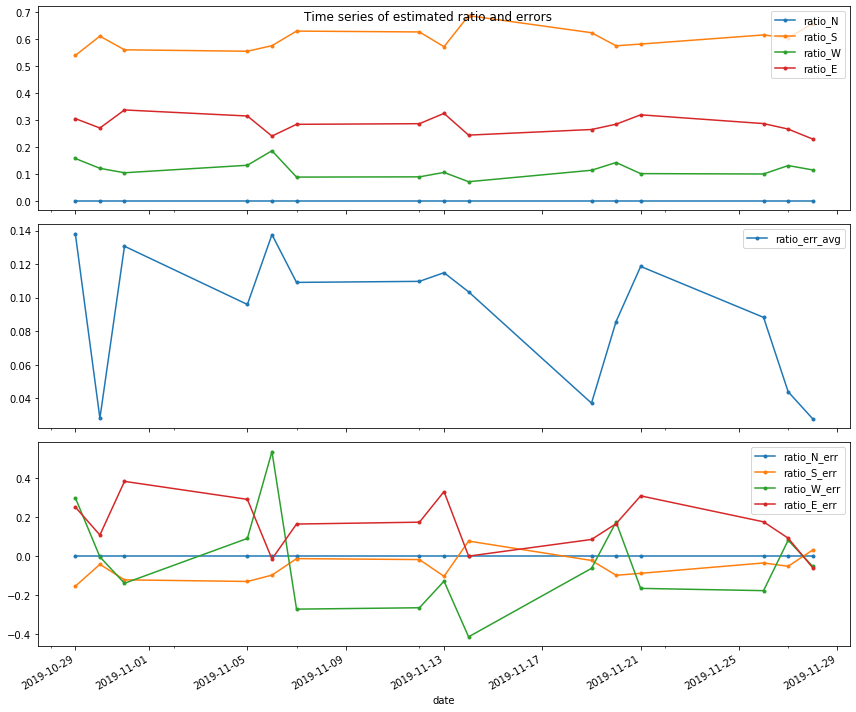

Main Street East and Maple / Sinclair
valid STC: 12, droped zero counts: 0
True ratios: N:0.32, S:0.33, W:0.16, E:0.18


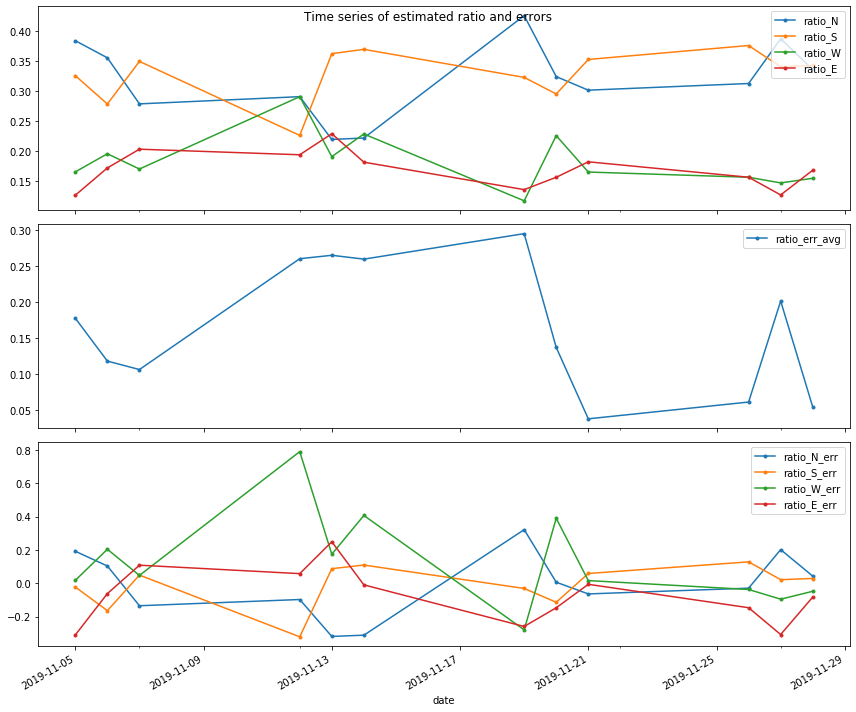

Fifth Line and Yukon Court
valid STC: 8, droped zero counts: 8
Thompson Road North and Maple Avenue
valid STC: 0, droped zero counts: 0
Thompson Road North and Woodward Avenue
valid STC: 0, droped zero counts: 0
Steeles Avenue East and Martin Street
valid STC: 0, droped zero counts: 0
Main Street West and Scott Boulevard
valid STC: 0, droped zero counts: 0
# of plots:  16


In [313]:
# plot ratio error time series for all intersections
path_to_data = './data/20180525-20200416-Milton-Ped-Volume-Per-Crosswalk.csv'
df_all = load_transform(path_to_data)
int_list = df_all.name.unique()

plot_counter = 0

for int_name in int_list:
    print(int_name)
    print("="*80)
    # get the df for the intersection
    df_int = get_df_intersection(df_all, int_name)
    
    # plot the count time series
    # plot_ts(df_int)

    # filter valid short-term counts
    df_int_d_valid = filter_valid_stc(df_int)
    
    # get the ratio estimates and errors
    df_int_d_valid = get_ratio_error(df_int_d_valid, df_int)
    if len(df_int_d_valid) == 0:
        continue

    # plot the ratio errors
    plot_ts_ratio_err(df_int_d_valid, df_int)
    plot_counter += 1

print('# of plots: ', plot_counter)
    